In [1]:
#### Necessary libraries ####
import numpy as np
import netCDF4 as nc 
import xarray as xr
import matplotlib.pyplot as plt 
import datetime 
import os
import cartopy.crs as crs
import cartopy
from cmocean import cm
from combine_data import * 

In [2]:
# Read data  
#case= "Pakistan"
#all_maps = read_data('/kyukon/scratch/gent/vo/000/gvo00090/vsc44251/intercomparison/', case)
#all_maps = xr.open_dataset('combine_data.nc') # Once there is a clean netcdf file with all data combined
pakistan_mask = xr.open_dataset('/kyukon/scratch/gent/vo/000/gvo00090/vsc44251/intercomparison/Pakistan/Mask_PakistanFlood_box_lon-180to180.nc')
path_to_data='/kyukon/scratch/gent/vo/000/gvo00090/vsc44251/intercomparison/'

Loading wam2layers data for Pakistan
Loading 2ldrm data for Pakistan
Loading utrack data for Pakistan
Skipping data for btrims, Pakistan - Unavailable
Loading tracmass data for Pakistan
Loading ughent data for Pakistan
Loading UIB data for Pakistan
Loading UniVie data for Pakistan
Loading CHc data for Pakistan
Loading xu data for Pakistan
Loading tatfancheng data for Pakistan
Loading uvigo data for Pakistan


(<Figure size 1600x1000 with 2 Axes>,
 <GeoAxes: title={'left': 'Standard deviation (absolute) of the models'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

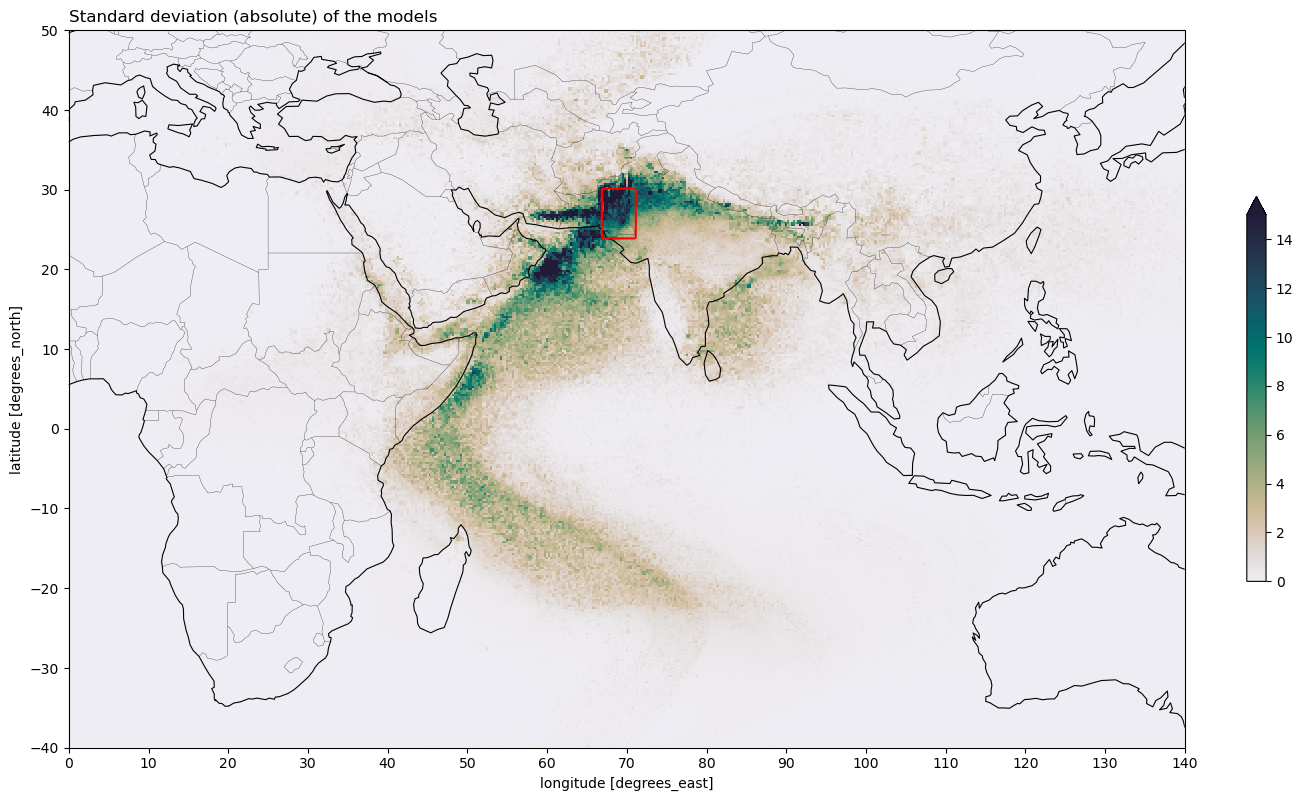

In [7]:
# Function to plot the (absolute) standard deviation (std)
def std_plot(mask, path_to_data, case, xlim=[0,140], ylim=[-40,50]):
    '''
    mask: the mask of your case
    path_to_data: path where you can find the data 
    xlim and ylim: limits for plotting in the latitude and longitude dimension
    '''
    # Read data
    all_maps = read_data(path_to_data, case) # THIS SHOULD BE CHANGED TO HANDLE THE THREE DIFFERENT CASES
    # Stack the data variables into a new dimension for computation
    stacked_data = all_maps.to_array(dim='variable')
    # Compute the standard deviation across the 'variable' dimension
    std_data = stacked_data.std(dim='variable')
    
    # Make figure of standard deviation between the different cases
    my_projection = crs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection=crs.PlateCarree())
    std_data.plot(vmin=0, vmax=15, robust=False, cmap=cm.rain, cbar_kwargs=dict(fraction=0.05, shrink=0.5),)
    
    # Add the mask
    contour = ax.contour(mask['lon'], mask['lat'], mask.mask, levels=[0.5], colors='r', linewidths=1.5)
    
    ax.set_title("Standard deviation (absolute) of the models", loc="left")
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
    
    ax.set_xticks(np.arange(-180, 181, 10), crs=my_projection)
    ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
    ax.set_xlim(xlim[0], xlim[1]) # Setting limits in latitude dimension, case-dependent 
    ax.set_ylim(ylim[0], ylim[1]) # Setting limits in longitude dimension, case-dependent
    #plt.savefig("Absolute_std.png")
    return fig, ax

std_plot(pakistan_mask, path_to_data, "Pakistan")


Loading wam2layers data for Pakistan
Loading 2ldrm data for Pakistan
Loading utrack data for Pakistan
Skipping data for btrims, Pakistan - Unavailable
Loading tracmass data for Pakistan
Loading ughent data for Pakistan
Loading UIB data for Pakistan
Loading UniVie data for Pakistan
Loading CHc data for Pakistan
Loading xu data for Pakistan
Loading tatfancheng data for Pakistan
Loading uvigo data for Pakistan


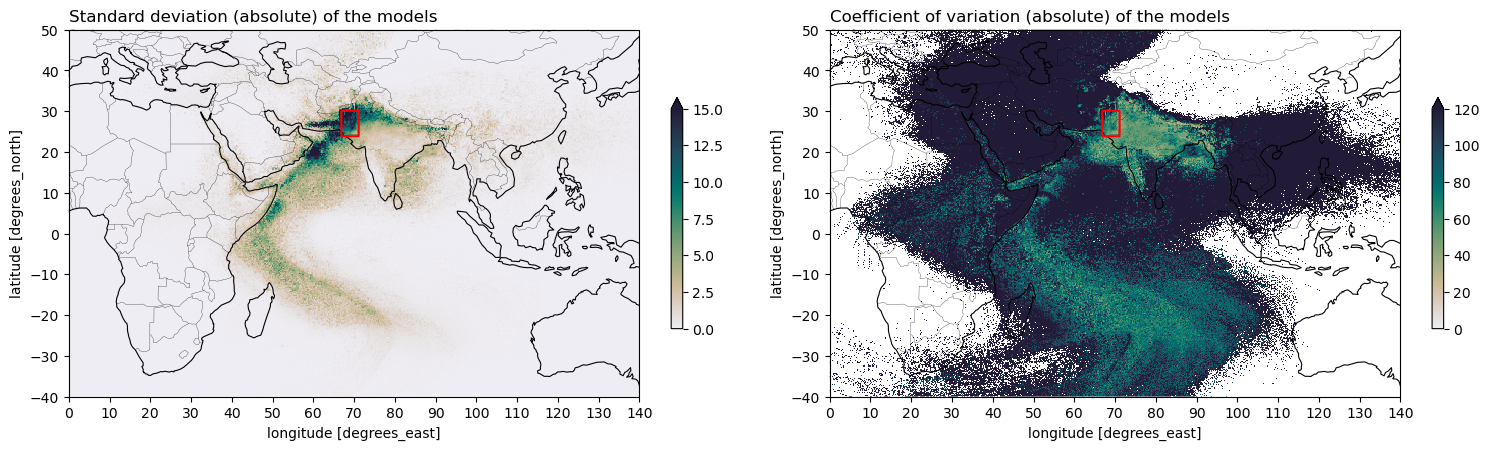

In [8]:
##% Function to plot the (absolute) std + CV (coefficient of variation) figure 
def std_cv_plot(mask, path_to_data,case, xlim=[0,140], ylim=[-40,50]):
    # Read data
    all_maps = read_data(path_to_data, case) # FOR when you want to use the read_data function
    #all_maps = xr.open_dataset('combined_data.nc') # FOR if there's a final .nc file
    # Stack the data variables into a new dimension for computation
    stacked_data = all_maps.to_array(dim='variable')
    # Compute the standard deviation across the 'variable' dimension
    std_data = stacked_data.std(dim='variable')
    
    # Compute the mean across the 'variable' dimension
    mean_data = stacked_data.mean(dim='variable')
    #OPTION 1: if you just use a mean data threshold (this is because if there's e.g. one model giving at a grid point a very small amount of mm, 
    #then the CV gets really big
    #mean_data = mean_data.where(mean_data >= 0.05, np.nan) 
    
    #OPTION 2: if more than half of the models have 0mm, then don't include it
    # Count the number of variables with value 0 at each (lat, lon) location + create mask
    zero_count = (stacked_data == 0).sum(dim='variable')
    zero_mask = zero_count >= 8
    # Apply the zero mask to mean_data, replacing those values with NaN
    mean_data = mean_data.where(~zero_mask, np.nan)
    
    # Compute the std/mean (coefficient of variation)
    CV_data = (std_data/mean_data)*100
    
    # Make figure of standard deviation and CV between the different cases
    my_projection = crs.PlateCarree(central_longitude=0)
    fig, axs = plt.subplots(1, 2, figsize=(18, 6), subplot_kw={'projection': crs.PlateCarree()}, sharey=False)
    
    data_list = [std_data, CV_data]
    titles = ["Standard deviation (absolute) of the models", "Coefficient of variation (absolute) of the models"]
    vmax_list = [15, 120]
    
    for ax, data, title, vmax in zip(axs, data_list, titles, vmax_list):
        data.plot(
            vmin=0,
            vmax=vmax,
            robust=False,
            cmap=cm.rain,
            cbar_kwargs=dict(fraction=0.05, shrink=0.5),
            ax=ax
        )
        ax.contour(mask['lon'], mask['lat'], mask.mask, levels=[0.5], colors='r', linewidths=1.5) # plot the mask
        ax.set_title(title, loc="left")
        ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=0.2)
        ax.set_xticks(np.arange(-180, 181, 10), crs=crs.PlateCarree())
        ax.set_yticks(np.arange(-90, 91, 10), crs=crs.PlateCarree())
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])
    
    # plt.savefig("Absolute_std.png")
std_cv_plot(pakistan_mask, path_to_data, "Pakistan")

Loading wam2layers data for Pakistan
Loading 2ldrm data for Pakistan
Loading utrack data for Pakistan
Skipping data for btrims, Pakistan - Unavailable
Loading tracmass data for Pakistan
Loading ughent data for Pakistan
Loading UIB data for Pakistan
Loading UniVie data for Pakistan
Loading CHc data for Pakistan
Loading xu data for Pakistan
Loading tatfancheng data for Pakistan
Loading uvigo data for Pakistan


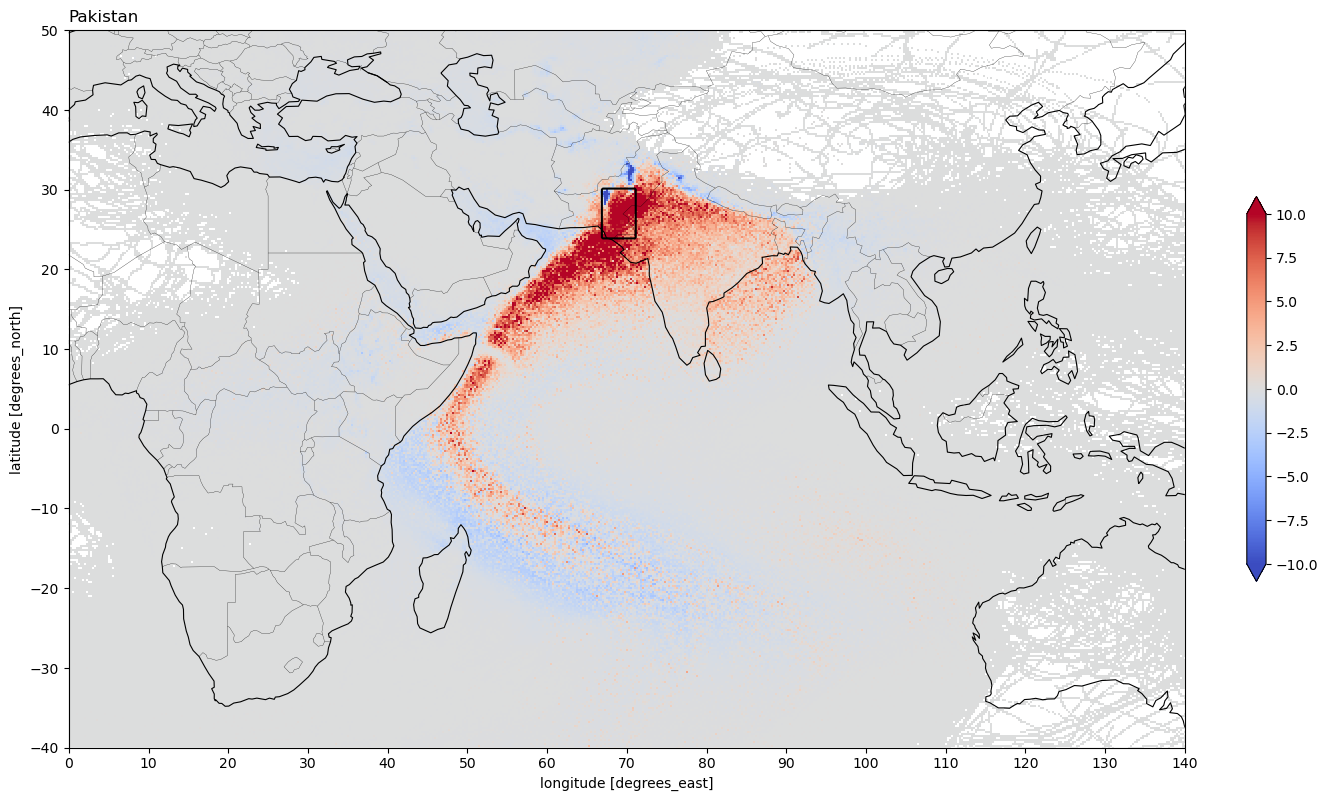

In [11]:
# Function to plot and show the absolute model difference between two models
def plot_difference(mask, model1, model2, path_to_data, case, xlim=[0,140], ylim=[-40,50]):
    '''
    model1 and model2: the 2 methods you want to compare
    '''
    # Read the data
    all_data = read_data(path_to_data, case) # now this is specific for pakistan, should be changed to take into account the different cases
    dataset1 = all_data[model1]
    dataset2 = all_data[model2]
    # Calculate the absolute difference between the 2 methods
    diff = dataset1 - dataset2
    diff = diff.where(diff != 0, np.nan)
    # Make figure
    my_projection = crs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(111, projection=crs.PlateCarree())
    diff.plot(vmin=-10, vmax=10, robust=False, cmap='coolwarm', cbar_kwargs=dict(fraction=0.05, shrink=0.5),)  
    
    ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
    ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
    ax.set_title(case, loc="left")
    ax.set_xticks(np.arange(-180, 181, 10), crs=my_projection)
    ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
    ax.set_xlim(xlim[0], xlim[1]) #Setting limits in longitude dimension
    ax.set_ylim(ylim[0], ylim[1]) #Setting limits in latitude dimension
    
    # Add mask
    contour = ax.contour(mask['lon'], mask['lat'], mask.mask, levels=[0.5], colors='k', linewidths=1.5)    
    return fig, ax, diff

_,_,diff=plot_difference(pakistan_mask, 'FLEXPART-HAMSTER Ens4', 'UTrack Ens1', path_to_data, "Pakistan")

Loading wam2layers data for Pakistan
Loading 2ldrm data for Pakistan
Loading utrack data for Pakistan
Skipping data for btrims, Pakistan - Unavailable
Loading tracmass data for Pakistan
Loading ughent data for Pakistan
Loading UIB data for Pakistan
Loading UniVie data for Pakistan
Loading CHc data for Pakistan
Loading xu data for Pakistan
Loading tatfancheng data for Pakistan
Loading uvigo data for Pakistan


(<Figure size 1800x600 with 6 Axes>,
 array([<GeoAxes: title={'left': 'Pakistan'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
        <GeoAxes: title={'left': 'Australia'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
        <GeoAxes: title={'left': 'Scotland'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>],
       dtype=object))

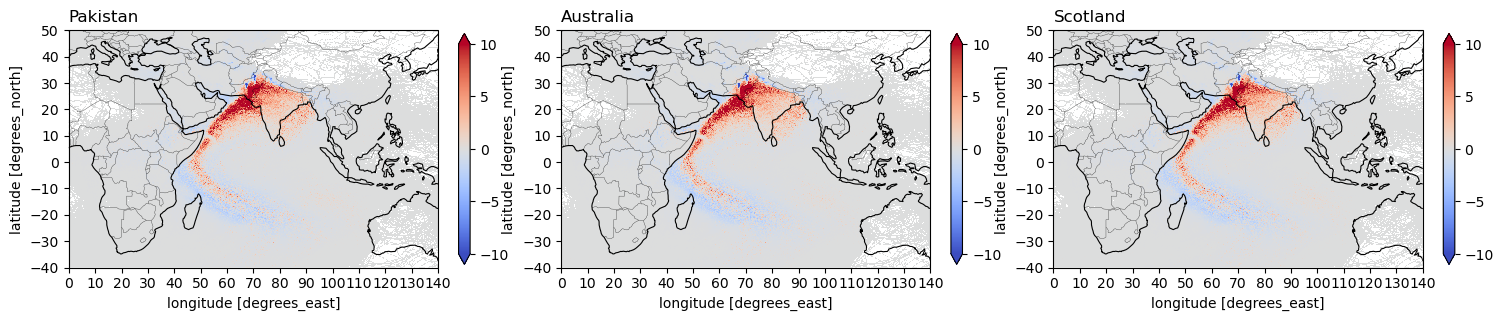

In [3]:
#To compare two models (show the absolute difference between two models) for all the cases (so with subplots)
#TO DO: now it just shows three times Pakistan, change to show Australia and Scotland on panel 2 and 3
#Not finished, work in progress (but probably not necessary anyway)
def plot_difference(model1, model2, path_to_data, case):
    all_data = read_data(path_to_data, case)
    vmin=-10
    vmax=abs(vmin)
    my_projection = crs.PlateCarree(central_longitude=0)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': crs.PlateCarree()}, sharey=False)
    cases = ['Pakistan', 'Australia', 'Scotland']
    for ax, case in zip(axs, cases):
        dataset = all_data
        diff = all_data[model1] - all_data[model2]
        diff = diff.where(diff != 0, np.nan)
        diff.plot(vmin=vmin, vmax=vmax, robust=False, cmap='coolwarm', cbar_kwargs=dict(fraction=0.05, shrink=0.5), ax=ax)
        ax.set_title(case, loc="left")
        ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
        ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
        ax.set_xticks(np.arange(-180, 181, 10), crs=my_projection)
        ax.set_yticks(np.arange(-90, 91, 10), crs=my_projection)
        ax.set_xlim(0, 140)  # Setting limits in longitude dimension
        ax.set_ylim(-40, 50)  # Setting limits in latitude dimension

    return fig, axs

plot_difference('FLEXPART-HAMSTER Ens4', 'UTrack Ens1', path_to_data, "Pakistan")


Loading wam2layers data for Pakistan
Loading 2ldrm data for Pakistan
Loading utrack data for Pakistan
Skipping data for btrims, Pakistan - Unavailable
Loading tracmass data for Pakistan
Loading ughent data for Pakistan
Loading UIB data for Pakistan
Loading UniVie data for Pakistan
Loading CHc data for Pakistan
Loading xu data for Pakistan
Loading tatfancheng data for Pakistan
Loading uvigo data for Pakistan


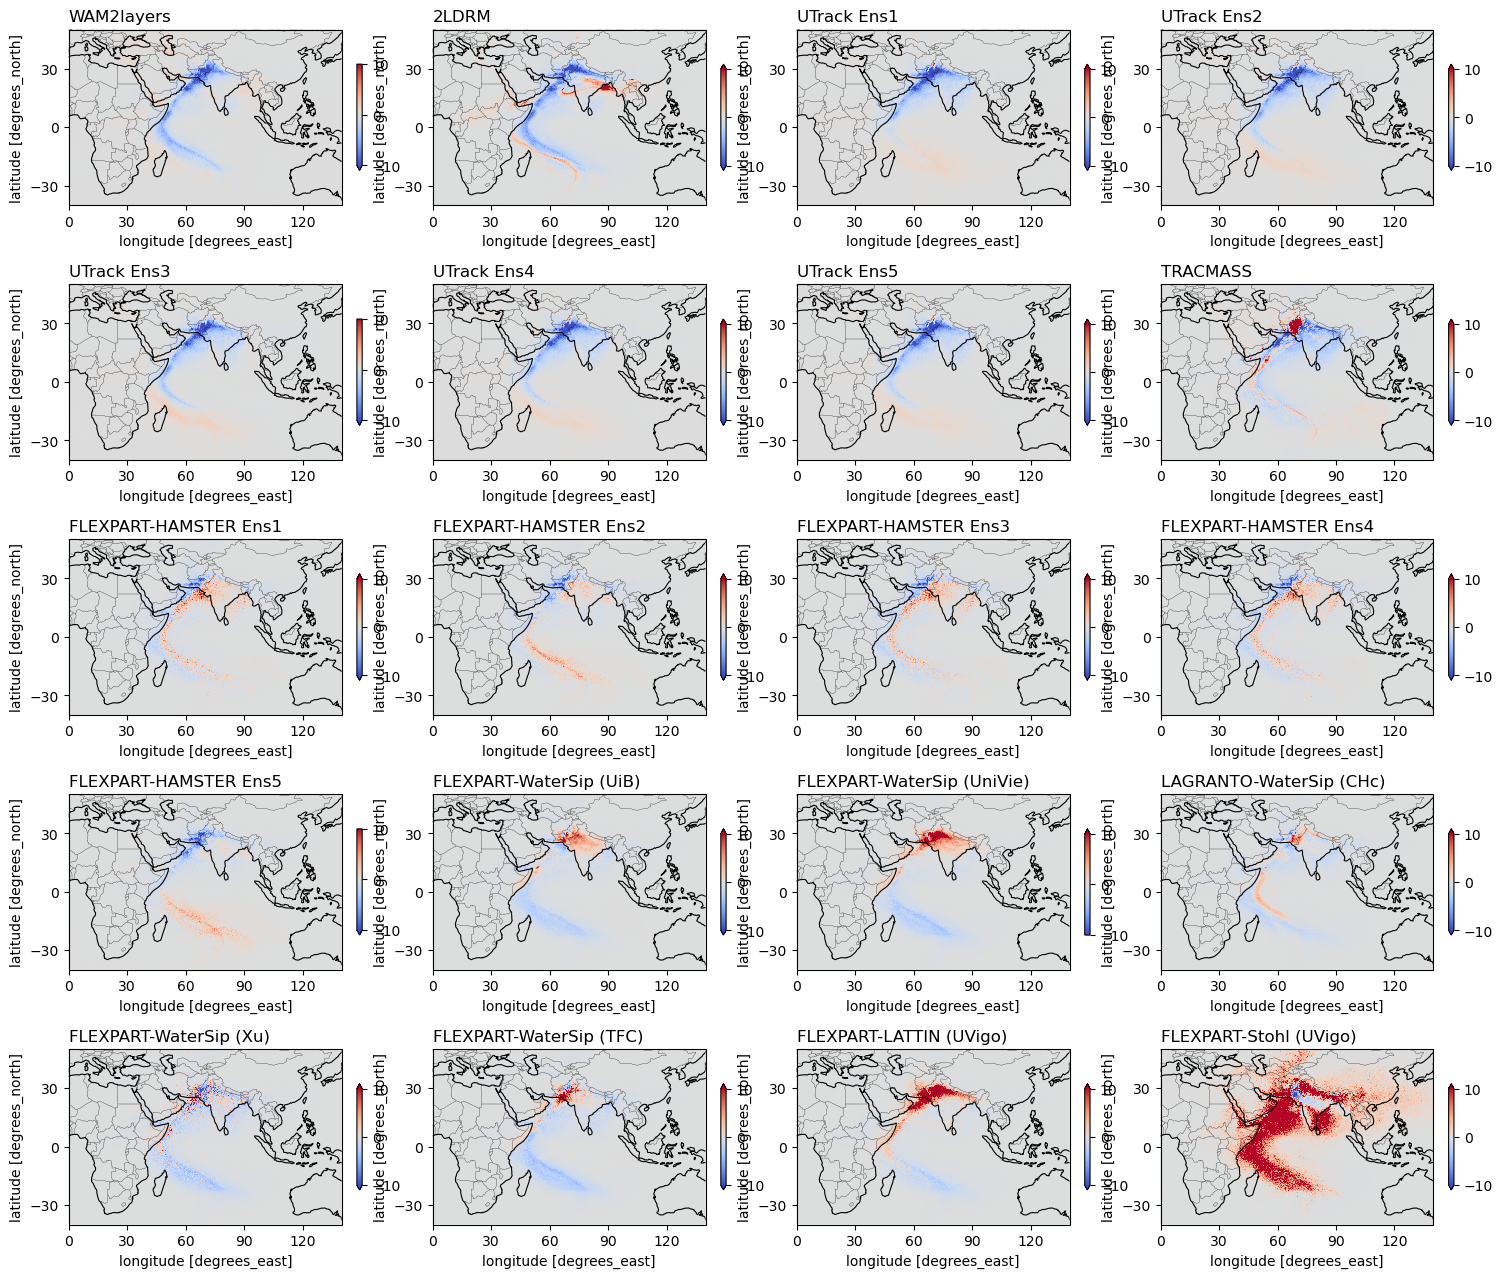

In [4]:
# Function to plot for all of the methods the difference from the mean (mean over the different methods)
def diff_from_mean_plot(path_to_data, case, xlim=[0,140], ylim=[-40,50], vmin=-10):
    # Read data
    all_maps = read_data(path_to_data, case)
    model_names = list(all_maps.keys())
    # Stack the data variables into a new dimension for computation
    stacked_data = all_maps.to_array(dim='variable')
    nr_var = len(stacked_data['variable'])  # number of models
    stacked_data = stacked_data.fillna(0)
    # Calculate the mean over all models
    mean_data = stacked_data.mean(dim='variable')
    # Calculate the difference from the mean
    mean_diff = stacked_data - mean_data
    
    # Make the figure
    my_projection = crs.PlateCarree(central_longitude=0)
    fig, axs = plt.subplots(5, 4, figsize=(18, 16), subplot_kw={'projection': crs.PlateCarree()}, sharey=False)
    axs=axs.flatten()

    vmax = abs(vmin)
    for i,ax in enumerate(axs):
        if i < nr_var:
            mean_diff[i].plot(vmin=vmin, vmax=vmax, robust=False, cmap='coolwarm', cbar_kwargs=dict(fraction=0.05, shrink=0.5), ax=ax)
            ax.set_title("") 
            ax.set_title(model_names[i], loc="left")
            ax.add_feature(cartopy.feature.COASTLINE, linewidth=0.8)
            ax.add_feature(cartopy.feature.BORDERS, linestyle='-', linewidth=.2)
            ax.set_xticks(np.arange(-180, 181, 30), crs=my_projection)
            ax.set_yticks(np.arange(-90, 91, 30), crs=my_projection)
            ax.set_xlim(xlim[0], xlim[1])
            ax.set_ylim(ylim[0], ylim[1])
        else:
            ax.set_visible(False)

diff_from_mean_plot(path_to_data, "Pakistan")    